In [10]:
import xpress as xp
import pandas as pd
import numpy as np
import math
import json

In [11]:
with open('stage1_res.json','r')  as f:
    ppl_info = json.load(f)

In [12]:
MAX_SEARCH_TIME = 20

table_seats = [ 21, 16, 26, 10, 20, 17 ]
table_case_idx = [2,0,1,0,0,0]

special_table_type = [1,0,1,0,0,0]
# define special case for high table
# ppl id 5 needs to be placed to seat ?
# ppl id 21 needs to be placed to seat ?


#list for visiualization
id_all = []


PPL_IDX_END_OF_HIGH_TABLE = 98
PPL_IDX_CENTER_OF_HIGH_TABLE = 92
END_OF_HIGH_TABLE_ID = 21 # to be corrected
BEGIN_OF_HIGH_TABLE_ID = 5 # to be corre

In [13]:
output_str = ''
table_num = 6


for table_id in range(table_num):
    ppl_idx = [-1]
    gender = [-1]
    matric = [-1]
    is_ALUMNI  = [-1]
    is_STUDENT = [-1]
    is_FELLOW = [-1]
    # is_center_high_table = [-1]
    # is_end_high_table = [-1]
    for index,_ in enumerate(ppl_info['table_person_mapping']):
        if ppl_info['table_person_mapping'][index][table_id] == 1:
            ppl_idx.append(index+1)
            gender.append(ppl_info['gender'][index])
            matric.append(ppl_info['matric'][index])
            is_ALUMNI.append(ppl_info['is_ALUMNI'][index])
            is_STUDENT.append(ppl_info['is_STUDENT'][index])
            is_FELLOW.append(ppl_info['is_FELLOW'][index])

    print(sum(is_ALUMNI)+sum(is_STUDENT)+sum(is_FELLOW),len(ppl_idx),len(matric),len(ppl_idx),len(gender),table_seats[table_id])
    assert  len(ppl_idx) ==len(matric)== len(ppl_idx) == len(gender) 
    model = xp.problem()
    model.controls.maxtime = MAX_SEARCH_TIME 
    max_seats = num_seats = table_seats[table_id]

    num_guests = max_seats

    x=np.array([[xp.var(name=f'x{i}_{j}',vartype=xp.binary) for j in range(num_seats+2)] for i in range(num_guests+2)],dtype=xp.npvar)

    model.addVariable(x)

    for j in range(1,num_seats+1):
       model.addConstraint(xp.Sum(x[i, j] for i in range(1,num_guests+1)) == 1)

    for i in range(1,num_guests+1):
        model.addConstraint(x[i,-1]==0)
        model.addConstraint(x[i,0]==0)

    # one seat one guest
    for i in range(1,num_guests+1):
       model.addConstraint(xp.Sum(x[i, j] for j in range(1,num_seats+1)) == 1)

    # High table extra constraints
    if table_case_idx[table_id] == 2: 
        for i in range(1,num_guests+1):
            if ppl_idx[i] == PPL_IDX_END_OF_HIGH_TABLE:
                model.addConstraint(x[i,END_OF_HIGH_TABLE_ID]==1)
            if ppl_idx[i] == PPL_IDX_CENTER_OF_HIGH_TABLE:
                model.addConstraint(x[i,BEGIN_OF_HIGH_TABLE_ID]==1)

    #constraint 3.18 and 3.19
    
    for k in range(1,num_seats+1): 
        for i in range(1,num_guests+1):
            if gender[i] == 1:
                model.addConstraint(1-x[i,k]>=xp.Sum(x[a,k-1]+x[a,k+1] for a in range(1,num_guests+1) if gender[a] == 1 ))
            if gender[i ]== -1:
                model.addConstraint(1-x[i,k]>=xp.Sum(x[a,k-1]+x[a,k+1] for a in range(1,num_guests+1) if gender[a] == -1 ))
        # #for female constraint
        # model.addConstraint(1-x[i,k]>=xp.Sum(x[i,k+1]+x[i,k-1] for i in range(num_guests) if gender[i]== 1 ))
        # # for male constraint
        # model.addConstraint(1-x[i,k]>=xp.Sum(x[i,k+1]+x[i,k-1] for i in range(num_guests) if gender[i]== -1 ))

    # The first type of tables in the hall
    if table_case_idx[table_id] == 0:
        #constraints 3.26 3.27
        for k in range(1,num_seats+1):
            for i in range(1,num_guests+1):
                if is_ALUMNI[i] == 1:
                    model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,k+1]+x[a,max_seats+1-k] for a in range(1,num_guests+1) if is_STUDENT[a] == 1))
                if is_STUDENT[i] == 1:
                    model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,k+1]+x[a,max_seats+1-k] for a in range(1,num_guests+1) if is_ALUMNI[a] == 1))


    # The second type of tables in the hall
    elif table_case_idx[table_id] == 1:

        for k in range(2,num_seats):   # to exclude the first and last seat
            for i in range(1,num_guests+1):
                if is_ALUMNI[i] == 1:
                    model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,k+1]+x[a,max_seats-k] for a in range(1,num_guests+1) if is_STUDENT[a] == 1))
                if is_STUDENT[i] == 1:
                    model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,k+1]+x[a,max_seats-k] for a in range(1,num_guests+1) if is_ALUMNI[a] == 1))

        for i in range(1,num_guests+1):
            k = 1
            if is_ALUMNI[i] == 1:
                model.addConstraint(x[i,k] <= xp.Sum(x[a,k+1]+x[a,max_seats]+x[a,max_seats-k] for a in range(1,num_guests+1) if is_STUDENT[a] == 1))
            if is_STUDENT[i] == 1:
                model.addConstraint(x[i,k] <= xp.Sum(x[a,k+1]+x[a,max_seats]+x[a,max_seats-k] for a in range(1,num_guests+1) if is_ALUMNI[a] == 1))
            k = max_seats
            if is_ALUMNI[i] == 1:
                model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,0] for a in range(1,num_guests+1) if is_STUDENT[a] == 1))
            if is_STUDENT[i] == 1:
                model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,0] for a in range(1,num_guests+1) if is_ALUMNI[a] == 1))
        

    # The third type of tables in the hall(high table)
    elif table_case_idx[table_id] == 2:
        k11 = [2,3,4,16,17,18,19,20]
        k12 = [6,7,8,9,10,11,12,13,14,15]

        for k in k11:
            for i in range(1,num_guests+1):
                if is_ALUMNI[i] == 1:
                    model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,k+1]+x[a,max_seats-k] for a in range(1,num_guests+1) if is_STUDENT[a] == 1))
                if is_STUDENT[i] == 1:
                    model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,k+1]+x[a,max_seats-k] for a in range(1,num_guests+1) if is_ALUMNI[a] == 1))
        for k in k12:
            for i in range(1,num_guests+1):
                if is_STUDENT[i] ==1:
                    model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,k+1]+x[a,max_seats-1-k] for a in range(1,num_guests+1) if is_ALUMNI[a] == 1))
                if is_ALUMNI[i] ==1:
                    model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,k+1]+x[a,max_seats-1-k] for a in range(1,num_guests+1) if is_STUDENT[a] == 1))
        
        k = 5
        for i in range(1,num_guests+1):
            if is_STUDENT[i] == 1:
                model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,k+1]+x[a,max_seats-1-k]+x[a,max_seats-k] for a in range(num_guests) if is_ALUMNI[a] == 1))
        
        for i in range(1,num_guests+1):
            k = 1
            if is_ALUMNI[i] == 1:
                model.addConstraint(x[i,k] <= xp.Sum(x[a,k+1]+x[a,max_seats]+x[a,max_seats-k] for a in range(1,num_guests+1) if is_STUDENT[a] == 1))
            if is_STUDENT[i] == 1:
                model.addConstraint(x[i,k] <= xp.Sum(x[a,k+1]+x[a,max_seats]+x[a,max_seats-k] for a in range(1,num_guests+1) if is_ALUMNI[a] == 1))
            k = max_seats
            if is_ALUMNI[i] == 1:
                model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,0] for a in range(1,num_guests+1) if is_STUDENT[a] == 1))
            if is_STUDENT[i] == 1:
                model.addConstraint(x[i,k] <= xp.Sum(x[a,k-1]+x[a,0] for a in range(1,num_guests+1) if is_ALUMNI[a] == 1))
        
    # use constraint to limit fellow position
    for k in range(1,num_seats+1):
        for i in range(1,num_guests+1):
            if is_FELLOW[i] == 1:
                model.addConstraint(1-x[i,k]>= xp.Sum(x[a,k-1]+x[a,k+1] for a in range(1,num_guests+1) if is_FELLOW[a] == 1))
            
    # special table type (for table 1 and table 3)
    if special_table_type[table_id] == 1:
        k = 1
        for i in range(1,num_guests+1):
            if is_FELLOW[i] == 1:
                model.addConstraint(x[i,k]==0)



    model.setObjective(xp.Sum(x[i,k] for i in range(1,num_guests+1) for k in range(num_seats)), sense=xp.maximize)
    
    
    
    # # mixed up male and female:
    # # todo
    # for i in range(num_guests):
    #     model.addConstraint(y[i] == xp.Sum(k*x[i,k] for k in range(num_seats)))
    # for i in range(num_guests):
    #     for a in range(num_guests):

    #         model.addConstraint(diff_seatnum[i,a]>= y[i]-y[a])
    #         model.addConstraint(diff_seatnum[i,a]>= y[a]-y[i])
    

    # # Objective function
    
    # model.setObjective(xp.Sum(xp.Sum(diff_seatnum[i,a] for i in range(num_guests) if is_FELLOW[i]==1 and i!=a ) for a in range(num_guests) if is_FELLOW[a]==1), sense=xp.maximize)
    
    model.optimize()
    res = model.getSolution(x)
    
    cur_output = ''
    cur_output+= f'table {table_id+1}: \n'
    guest_id = []# ppl_idx[i] for i in range(num_guests) if res
    guest_real_id = []
    for k in range(1,num_seats+1):
        for i in range(1,num_guests+1):
            if res[i,k] == 1:
                guest_id.append(i)
                guest_real_id.append(ppl_idx[i])
                id_all.append(ppl_idx[i])
                
    cur_output += f"guests: {[i for i in guest_real_id]}\n"

    gender_all = []
    for i in guest_id:
        if gender[i] == 1:
            gender_all.append('male')
        elif gender[i] == -1:
            gender_all.append('female')
        else:
            gender_all.append('unknown')
    
    cur_output += f"gender: {gender_all}\n"
    ppl_type = []
    for i in guest_id:
        if is_FELLOW[i] == 1:
            ppl_type.append('fellow')
        elif is_ALUMNI[i] == 1:
            ppl_type.append('alumni')
        elif is_STUDENT[i] == 1:
            ppl_type.append('student')
    cur_output += f"ppl type: {ppl_type}\n"
    output_str += cur_output
print(output_str)

18 22 22 22 22 21
FICO Xpress v9.2.4, Hyper, solve started 16:34:17, Aug 21, 2024
Heap usage: 902KB (peak 902KB, 366KB system)
Maximizing MILP noname using up to 8 threads and up to 8006MB memory, with these control settings:
MAXTIME = 20
OUTPUTLOG = 1
Original problem has:
       709 rows          529 cols        11995 elements       529 entities
Presolved problem has:
       402 rows          347 cols         7184 elements       347 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 1073KB (peak 1613KB, 366KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  1.00e+00]
  RHS and bounds [min,max] : [ 1.00e+00,  1.00e+00] / [ 1.00e+00,  3.00e+00]
  Objective      [min,max] : [ 1.00e+00,  1.00e+00] / [      0.0,       0.0]
Autoscaling applied standard scaling

Symmetric problem: generators: 13, support set: 328
 Number of orbits: 88, largest orbit: 8
 Row orbits

 *** Search completed ***
Uncrunching matrix
Final MIP objective                   : 9.000000000000000e+00
Final MIP bound                       : 9.000000000000000e+00
  Solution time / primaldual integral :      0.02s/ 89.488791%
  Number of solutions found / nodes   :         1 /         1
  Max primal violation      (abs/rel) :       0.0 /       0.0
  Max integer violation     (abs    ) :       0.0
17 21 21 21 21 20
FICO Xpress v9.2.4, Hyper, solve started 16:34:17, Aug 21, 2024
Heap usage: 883KB (peak 883KB, 247KB system)
Maximizing MILP noname using up to 8 threads and up to 8006MB memory, with these control settings:
MAXTIME = 20
OUTPUTLOG = 1
Original problem has:
       680 rows          484 cols        11040 elements       484 entities
Presolved problem has:
       414 rows          400 cols         7836 elements       400 entities
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 1081KB (peak 1570KB, 247KB system)

Coefficient range                    origin

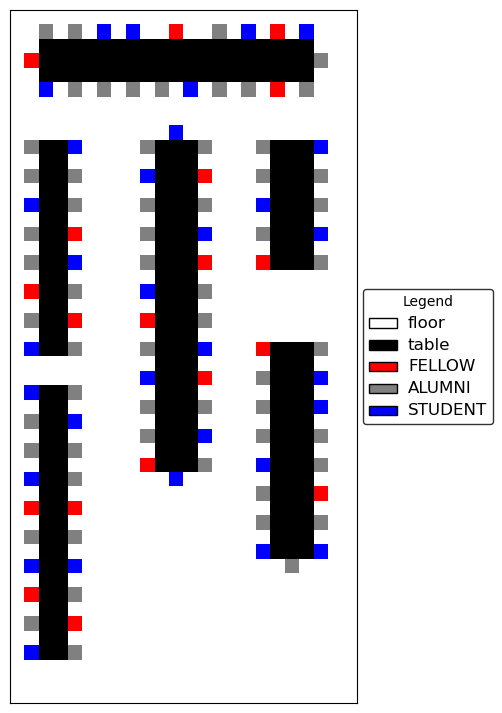

In [14]:
df2 = pd.read_excel("person.xlsx")

#person info 
num_guests = len(df2)

global_matric = df2['Matric'].tolist()
for index,value in enumerate(matric):
    if not math.isnan(value):
        global_matric[index] = int(global_matric[index]) 

global_gender = df2['Gender'].tolist()
for index,value in enumerate(gender):
    if value == 'M':
        global_gender[index] = 1
    elif value == "F":
        global_gender[index] = -1
    else: # None
        global_gender[index] = 0

global_ppl_type = df2['TYPE'].tolist()
NoA = 0
NoS = 0
NoF = 0
NoP = len(global_ppl_type)

global_is_ALUMNI = []
global_is_STUDENT = []
global_is_FELLOW = []
for index,value in enumerate(global_ppl_type):
    if value == 'ALUMNI':
        global_is_ALUMNI.append(1)
        global_is_STUDENT.append(0)
        global_is_FELLOW.append(0)

    elif value == 'STUDENT':
        global_is_ALUMNI.append(0)
        global_is_STUDENT.append(1)
        global_is_FELLOW.append(0)

    elif value == 'FELLOW':
        global_is_ALUMNI.append(0)
        global_is_STUDENT.append(0)
        global_is_FELLOW.append(1)


import matplotlib.pyplot as plt
import numpy as np
import copy


df = pd.read_excel("map110.xlsx")


matrix = df.to_numpy(dtype=np.int8)[1:,1:]


colors = {-1: (1, 1, 1), 0: (0, 0, 0), 1: (1, 0, 0), 2: (1, 1, 0), 3: (0, 1, 0), 4: (0.5, 0, 0.5)}
global_map = copy.deepcopy(matrix)

id_to_xy_mapping = {}
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        if matrix[i,j] > 0:
            id_to_xy_mapping[matrix[i,j]] = (i,j)
for i in range(global_map.shape[0]):
    for j in range(global_map.shape[1]):
        if global_map[i,j] > 0:
            cur_ppl_id = global_map[i,j]-1

            if global_is_FELLOW[id_all[cur_ppl_id]-1] == 1:
                global_map[i,j] = 1
            elif global_is_ALUMNI[id_all[cur_ppl_id]-1] == 1:
                global_map[i,j] = 2
            elif global_is_STUDENT[id_all[cur_ppl_id]-1] == 1:
                global_map[i,j] = 3


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# plt.ioff()
color_map = {
    -1: 'white',   # white for -1
    0: 'black',    # black for 0
    1: 'red',      # red for 1
    2: 'grey',   # yellow for 2
    3: 'blue'      # blue for 3
}

# 自定义标签
label_map = {
    -1: 'floor',
    0: 'table',
    1: 'FELLOW',
    2: 'ALUMNI',
    3: 'STUDENT'
}

import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap([color_map[x] for x in sorted(color_map.keys())])
cmap = mcolors.ListedColormap([color_map[x] for x in sorted(color_map.keys())])
fig, ax = plt.subplots(figsize=(15, 9))
ax.set_xticks([])
ax.set_yticks([])  
ax.tick_params(axis='both', which='both', length=0)  

boundaries = sorted(color_map.keys()) + [max(color_map.keys())+1]
norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

plt.imshow(global_map, cmap=cmap, norm=norm)


from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=color_map[key], edgecolor='black', label=label_map[key])
                   for key in sorted(label_map.keys())]

leg = ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Legend", frameon=True)
leg.get_frame().set_edgecolor('black')  

for text in leg.get_texts():
    text.set_fontsize(12)  

plt.subplots_adjust(right=0.8)
plt.show()


In [15]:
id_all

[5,
 33,
 60,
 83,
 92,
 28,
 76,
 106,
 68,
 38,
 42,
 96,
 12,
 39,
 78,
 48,
 23,
 30,
 19,
 74,
 98,
 47,
 7,
 72,
 37,
 32,
 93,
 15,
 66,
 35,
 109,
 9,
 80,
 108,
 6,
 31,
 88,
 3,
 61,
 53,
 21,
 43,
 73,
 95,
 16,
 89,
 11,
 10,
 100,
 75,
 59,
 63,
 20,
 94,
 82,
 57,
 18,
 104,
 86,
 25,
 102,
 8,
 81,
 36,
 34,
 71,
 56,
 97,
 27,
 70,
 52,
 51,
 64,
 79,
 13,
 1,
 87,
 107,
 49,
 85,
 101,
 14,
 90,
 26,
 99,
 29,
 77,
 44,
 110,
 55,
 40,
 84,
 4,
 105,
 46,
 17,
 2,
 91,
 22,
 58,
 65,
 24,
 62,
 41,
 103,
 50,
 45,
 67,
 69,
 54]

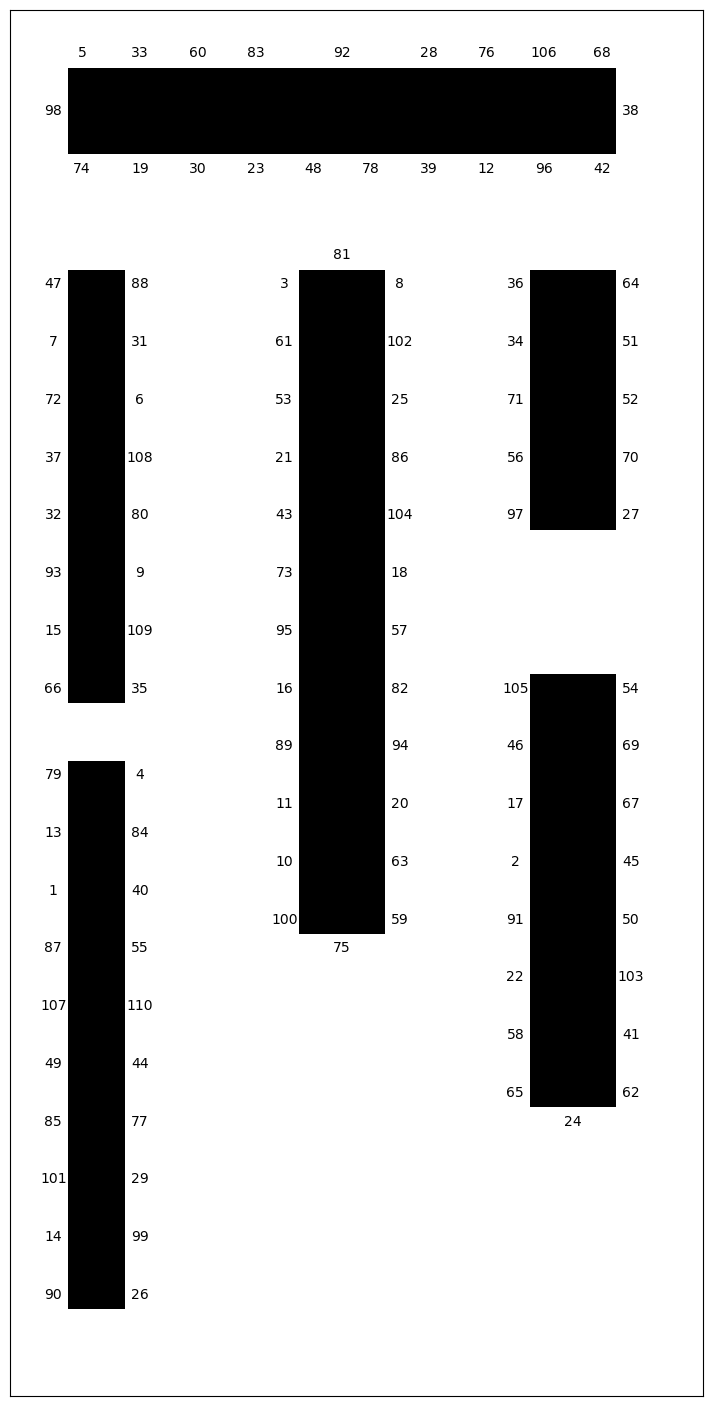

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import copy
# read file

df = pd.read_excel("map110.xlsx")
global_map = copy.deepcopy(matrix)
global_map_idx = [['' for _ in range(global_map.shape[1])] for _ in range(global_map.shape[0])]


for i in range(global_map.shape[0]):
    for j in range(global_map.shape[1]):
        if global_map[i,j] > 0:
            global_map_idx[i][j] = str(id_all[global_map[i,j]-1])
            global_map[i][j] = 1
            


label_map = {
    -1:"floor",
    0:"table",
}

color_map = {
    -1: 'white',    
    0: 'black',     
    1: 'white',       
}


cmap = mcolors.ListedColormap([color_map[x] for x in sorted(color_map.keys())])

fig, ax = plt.subplots(figsize=(30, 18))
ax.set_xticks([])  
ax.set_yticks([])  
ax.tick_params(axis='both', which='both', length=0)  

boundaries = sorted(color_map.keys()) + [max(color_map.keys()) + 1]

norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

plt.imshow(global_map, cmap=cmap, norm=norm)

for i in range(global_map.shape[0]):
    for j in range(global_map.shape[1]):
        if global_map_idx[i][j] != '':
            ax.text(j, i, global_map_idx[i][j], ha='center', va='center', fontsize=10, color='black')

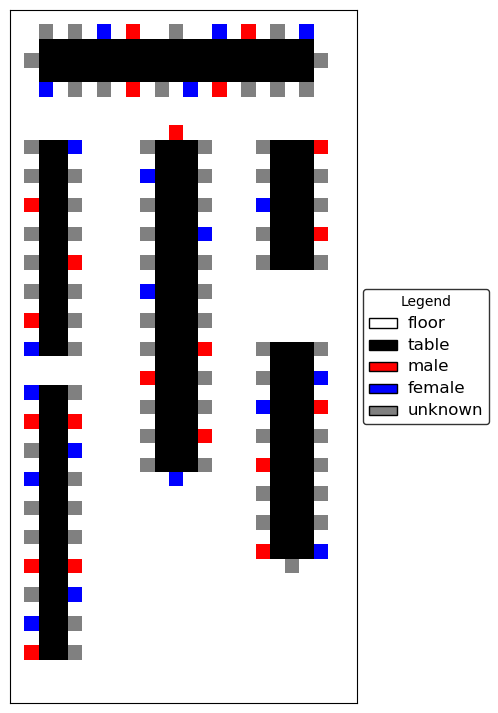

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# read file
file_path = "map110.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

matrix = df.to_numpy(dtype=np.int8)[1:,1:]

global_map = copy.deepcopy(matrix)
gender = ppl_info['gender']
gender_id_to_color_id = {
    1:1,
    -1:2,
    0:3
}

for i in range(global_map.shape[0]):
    for j in range(global_map.shape[1]):
        if global_map[i,j] > 0:
            cur_ppl_id = global_map[i,j]-1
            
            temp = id_all[cur_ppl_id]-1
            global_map[i,j] = gender_id_to_color_id[ ppl_info["gender"][temp]]


ppl_gender_mapping = {"male":1,"female":2,"unknown":3}


label_map = {
    -1:"floor",
    0:"table",
    1:"male",
    2:"female",
    3:"unknown" 
}

color_map = {
    -1: 'white',    
    0: 'black',     
    1: 'red',       
    2: 'blue',    
    3: 'grey',      
}

import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap([color_map[x] for x in sorted(color_map.keys())])
cmap = mcolors.ListedColormap([color_map[x] for x in sorted(color_map.keys())])
fig, ax = plt.subplots(figsize=(15, 9))
ax.set_xticks([])  
ax.set_yticks([])  
ax.tick_params(axis='both', which='both', length=0)  

boundaries = sorted(color_map.keys()) + [max(color_map.keys())+1]


norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

plt.imshow(global_map, cmap=cmap, norm=norm)

from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=color_map[key], edgecolor='black', label=label_map[key])
                   for key in sorted(label_map.keys())]

leg = ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Legend", frameon=True)
leg.get_frame().set_edgecolor('black')  

for text in leg.get_texts():
    text.set_fontsize(12)  

plt.subplots_adjust(right=0.8)
plt.show()

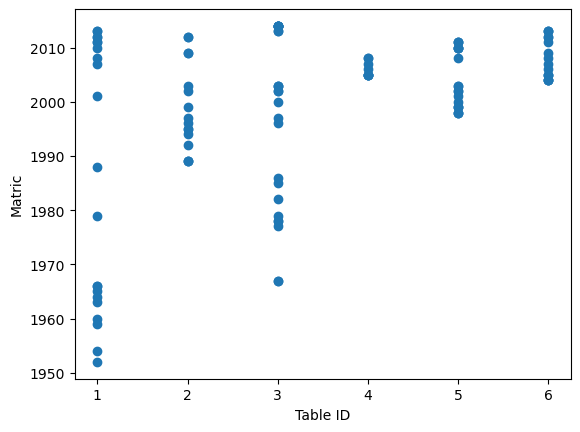

In [18]:
import matplotlib.pyplot as plt
x = []
y = []

matric_all = []
for table_id in range(table_num):
    matric = []
    # is_center_high_table = [-1]
    # is_end_high_table = [-1]
    for index,_ in enumerate(ppl_info['table_person_mapping']):
        if ppl_info['table_person_mapping'][index][table_id] == 1:
            if not math.isnan(ppl_info['matric'][index]):
                matric.append(ppl_info['matric'][index])
    matric_all.append(matric)
for i, sublist in enumerate(matric_all, start=1):
    x.extend([i] * len(sublist))
    y.extend(sublist)

plt.xlabel('Table ID')
plt.ylabel('Matric')

plt.scatter(x, y)
plt.show()